In [1]:
library("geosphere")
library("ggplot2")
library("igraph", warn.conflicts = FALSE)
library("viridis")

Loading required package: viridisLite



In [2]:
nodes <- read.csv("ITA_nodes.csv")
edges <- read.csv("ITA_edges.csv")

cat(sprintf("Columns nodes:"), colnames(nodes))
cat(sprintf("\nColumns edges:"), colnames(edges))

num_nodes <- length(seq_along(nodes$lat))
num_edges <- length(seq_along(edges$from))

cat(sprintf("Number of nodes:"), num_nodes)
cat(sprintf("\nNumber of edges:"), num_edges)

Columns nodes: adm_id population adm_name adm_code lat lon nuts3 GDPpc urbn_type
Columns edges: from to length_km estimated_flowNumber of nodes: 110
Number of edges: 4129

In [3]:
nodes$lat <- as.numeric(nodes$lat)
nodes$lon <- as.numeric(nodes$lon)

# Order nodes by adm_id, then update rownames
# (now each rowname is equal to the adm_id)

nodes <- nodes[order(nodes$adm_id), ]
rownames(nodes) <- nodes$adm_id

In [4]:
cat(sprintf("Order of magnitude of the estimated flows of people in the data:"),
    sum(edges$estimated_flow) * 1e-6, sprintf("millions."))

pol_edges <- edges[which(edges$from != edges$to & edges$estimated_flow > 0), ]
num_pol_edges <- length(seq_along(pol_edges$from))

cat(sprintf("\nOrder of magnitude of the estimated flows of people in the data, without considering self-loops and edges with 0 flow:"), # nolint
    sum(pol_edges$estimated_flow) * 1e-6, sprintf("millions."))

cat(sprintf("\n\nNumber of edges (after polishing:)"), num_pol_edges)

Order of magnitude of the estimated flows of people in the data: 57.57352 millions.


Order of magnitude of the estimated flows of people in the data, without considering self-loops and edges with 0 flow: 4.427521 millions.

Number of edges (after polishing:) 3903

In [5]:
# length_km is already the distance between nodes in the edges dataset. We want
# check wether if they are correctly computed (using lat and lon), so we use the
# Haversine distance method from geospehere (converted in km).

pol_edges$haversine <- 1e-3 * distHaversine(cbind(nodes[pol_edges$from, ]$lon,
                                                  nodes[pol_edges$from, ]$lat),
                                            cbind(nodes[pol_edges$to, ]$lon,
                                                  nodes[pol_edges$to, ]$lat))

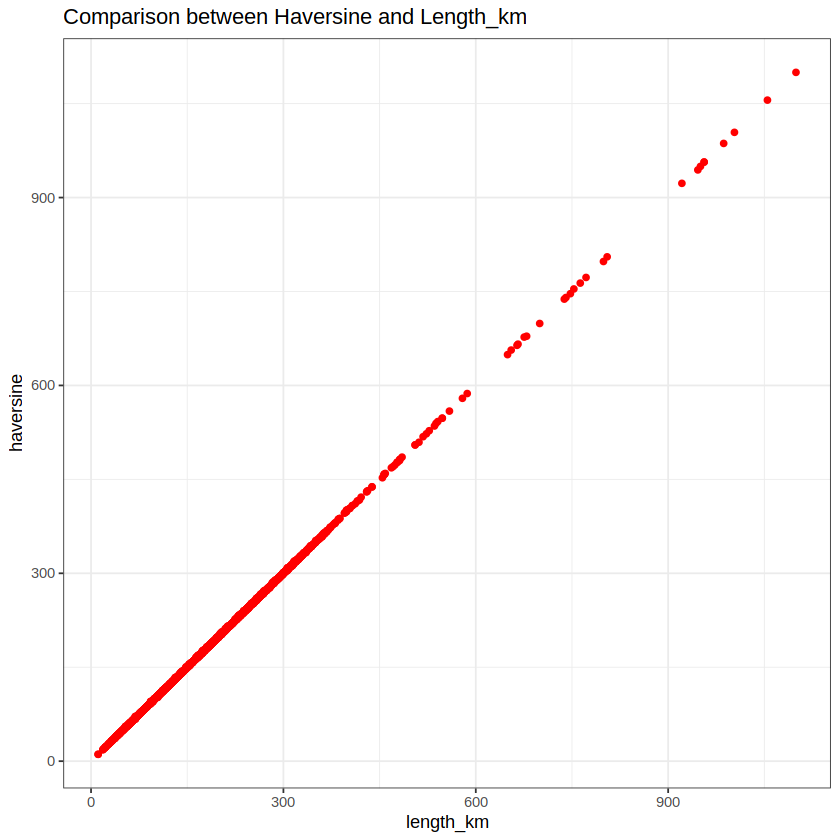

In [6]:
# Now we plot the two length, we expect a y = x line

ggplot(pol_edges, aes(x = length_km, y = haversine)) +
  theme_bw() +
  geom_point(color = "red", size = 1.5) +
  labs(title = "Comparison between Haversine and Length_km",
       x = "length_km",
       y = "haversine")

In [7]:
# Now we want to visualize the network: in order to do so, we comsider the
# columns "from" and "to" from pol_edges (the one without self loops), sorting
# the nodes indexing. Then we use the estimated_flow for the weigths of the
# edges and for the populations of the vertices we use nodes' populations.

g <- graph_from_data_frame(pol_edges[, c("from", "to")], directed = TRUE,
                           vertices = sort(nodes$adm_id))

E(g)$weight <- pol_edges$estimated_flow
V(g)$pop <- nodes$population
V(g)$label <- nodes$adm_name

layout <- matrix(data = NA, nrow = nrow(nodes), ncol = 2)
layout[, 1] <- nodes$lon
layout[, 2] <- nodes$lat

# Then, we compute the sizes of nodes and edges: for an edge we simply take the
# weigth, while for a node we consider the strength of a node (with mode = "all"
# which means we are doing outflow - inflow) and then taking the sqrt.

sizes_nodes <- sqrt(strength(g, mode = "all"))
sizes_edges <- E(g)$weight

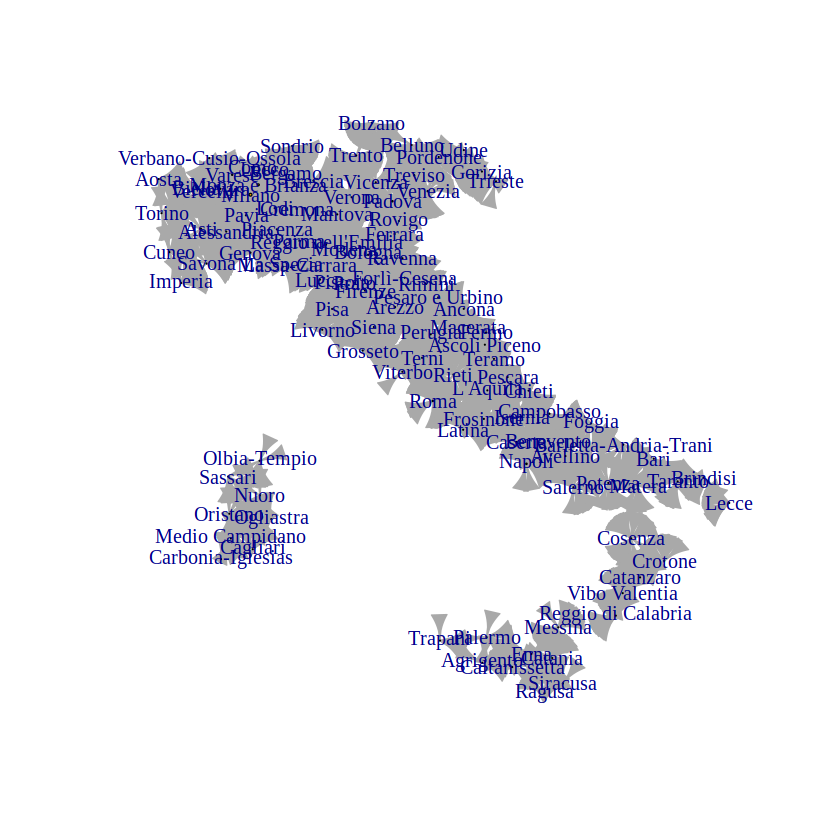

In [8]:
# First we want to visualize the labels of the cities.

plot(g, layout = layout, vertex.size = sizes_nodes / max(sizes_nodes),
     edge.width = sizes_edges / max(sizes_edges))

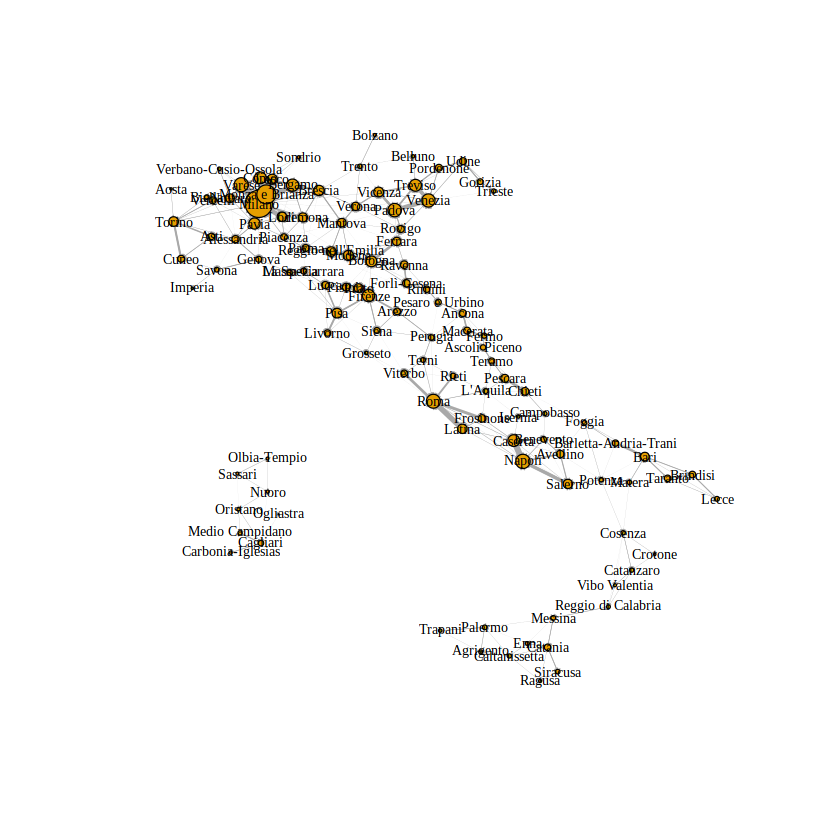

In [9]:
# From the previous graph nothing was clear, so now we want to rescale the whole
# graph, reducing the labels and the arrows sizes and increasing vertices sizes.

plot(g, layout = layout,
     vertex.label = V(g)$label,
     vertex.label.cex = 0.7,
     vertex.label.color = "black",
     vertex.size = 10 * sizes_nodes / max(sizes_nodes),
     edge.arrow.size = 0.05,
     edge.arrow.width = 0.05,
     edge.width = 15 * sizes_edges / max(sizes_edges))

In [10]:
# This function takes a vector and maps its values to a color palette
# based on the provided palette; it returns a vector of colors
# corresponding to the values in the input vector.

vec2pal <- function(x, palette) {
  n <- length(palette)
  max_x <- max(x)
  min_x <- min(x)
  idx <- floor((x - min_x) / (max_x - min_x) * (n - 1)) + 1
  return(palette[idx])
}

mypal <- viridis_pal()(10)

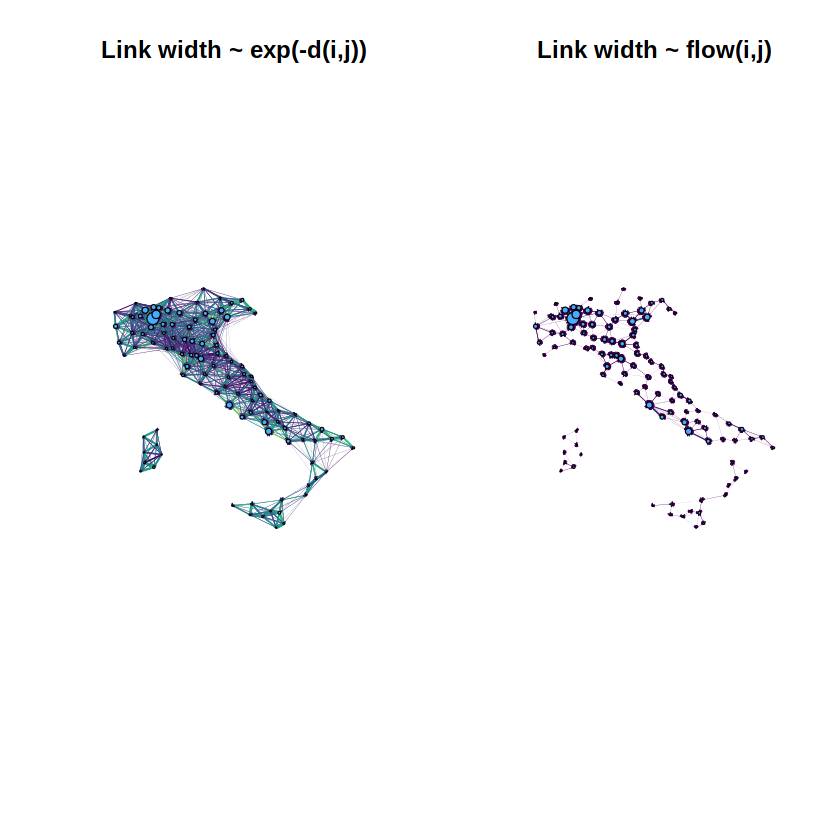

In [11]:
# Now we can visualize what happens when the edges sizes are proportional to
# exp(-d(i,j)) or simply to the weights (=flows) of the graph.

par(mfrow = c(1, 2))

w <- log10(E(g)$weight)
edge_colors <- vec2pal(w, mypal)
sizes_edges <- exp(- pol_edges$haversine / 40)

plot(g, layout = layout,
     vertex.label = NA,
     vertex.label.cex = 0.5,
     vertex.label.color = "#181616",
     vertex.color = "#47acff",
     vertex.size = 10 * sizes_nodes / max(sizes_nodes),
     edge.arrow.size = 0.05,
     edge.arrow.width = 0.05,
     edge.width = 5 * sizes_edges / max(sizes_edges),
     edge.color = edge_colors,
     main = "Link width ~ exp(-d(i,j))")

w <- E(g)$weight
edge_colors <- vec2pal(w, mypal)
sizes_edges <- w

plot(g, layout = layout,
     vertex.label = NA,
     vertex.label.cex = 0.5,
     vertex.label.color = "#181616",
     vertex.color = "#47acff",
     vertex.size = 10 * sizes_nodes / max(sizes_nodes),
     edge.arrow.size = 0.05,
     edge.arrow.width = 0.05,
     edge.width = 5 * sizes_edges / max(sizes_edges),
     edge.color = edge_colors,
     main = "Link width ~ flow(i,j)")

In [12]:
# We build the matrix of the distances d(i, j) that will be used in the two
# models (gravity and radiation) that we will later implement.

distances <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in seq_along(nodes$lat)) {
  for (j in seq_along(nodes$lat)) {
    distances[i, j] <- 1e-3 * distHaversine(c(nodes$lon[i], nodes$lat[i]),
                                            c(nodes$lon[j], nodes$lat[j]))
  }
}

In [13]:
# Now we build the matrix of the expected_flows, which will be the weigths
# in the models we are gonna code (NB: we impose the condition that the edge
# must exist, or it is set to 0).

flows <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in seq_along(nodes$lat)) {
  for (j in seq_along(nodes$lat)) {
    matched_edges <- pol_edges$estimated_flow[pol_edges$from == i &
                                                pol_edges$to == j]

    if (length(matched_edges) > 0) {
      flows[i, j] <- matched_edges[1]
    } else {
      flows[i, j] <- 0
    }
  }
}

In [14]:
# Here we define the Gravity model, where we consider as denominator the
# exponential of the distance between nodes. The parameters are 4: alpha and
# beta (exponents of the pops), k (norm factor) and d0 (length scale).

GravityModel <- function(nodes, distances, i, j, alpha, beta, k, d0) { # nolint
  num <- nodes$population[i] ^ alpha * nodes$population[j] ^ beta
  den <- exp(distances[i, j] / d0)

  return(k * num / den)
}

GravityModel(nodes, distances, 1, 2, -0.5, 1.2, 0.5, 52)

[1] 153.525

In [15]:
# We need somehow to fit our model to real_data, thus we define a loss function
# for this specific purpose, which simply computes the square of the distance
# between real and predicted data. Then we use optim for the fit: notice that it
# is A LOT dependent on initial params, so be careful changing them.

loss_function <- function(params, model, nodes, distances, flows) {
  loss <- 0

  for (i in seq_along(nodes$lat)) {
    for (j in seq_along(nodes$lat)) {
      predicted_flow <- model(nodes, distances, i, j, alpha = params[1],
                              beta = params[2], k = params[3], d0 = params[4])
      loss <- loss + (flows[i, j] - predicted_flow) ^ 2
    }
  }

  return(loss)
}

initial_params <- c(0.7, 0.6, 0.005, 10)

optimal_params <- optim(initial_params, loss_function, model = GravityModel,
                        nodes = nodes, distances = distances, flows = flows)$par

In [17]:
# Using the optimal parameters we compute te matrix of the real flows (which has
# all the possible edges). Then we transform it into the total edges dataframe,
# which allows us to have all the possible edges (even those not observed).

real_flows <- matrix(0, nrow = nrow(nodes), ncol = nrow(nodes))

for (i in seq_along(nodes$lat)) {
  for (j in seq_along(nodes$lat)) {
    if(i != j) {
      real_flows[i, j] <- GravityModel(nodes, distances, i, j,
                                       alpha = optimal_params[1],
                                       beta = optimal_params[2],
                                       k = optimal_params[3],
                                       d0 = optimal_params[4])
    }
  }
}

from <- numeric()
to <- numeric()
flow <- numeric()

for (i in 1:num_nodes) {
  for (j in 1:num_nodes) {
    if (real_flows[i, j] != 0) {
      from <- c(from, i)
      to <- c(to, j)
      flow <- c(flow, real_flows[i, j])
    }
  }
}

total_edges <- data.frame(from = from, to = to, flow = flow)

In [21]:
g <- graph_from_data_frame(total_edges[, c("from", "to")], directed = TRUE,
                           vertices = sort(nodes$adm_id))

E(g)$weight <- total_edges$flow
V(g)$pop <- nodes$population
V(g)$label <- nodes$adm_name

layout <- matrix(data = NA, nrow = num_nodes, ncol = 2)
layout[, 1] <- nodes$lon
layout[, 2] <- nodes$lat

sizes_nodes <- sqrt(strength(g, mode = "all"))
sizes_edges <- E(g)$weight

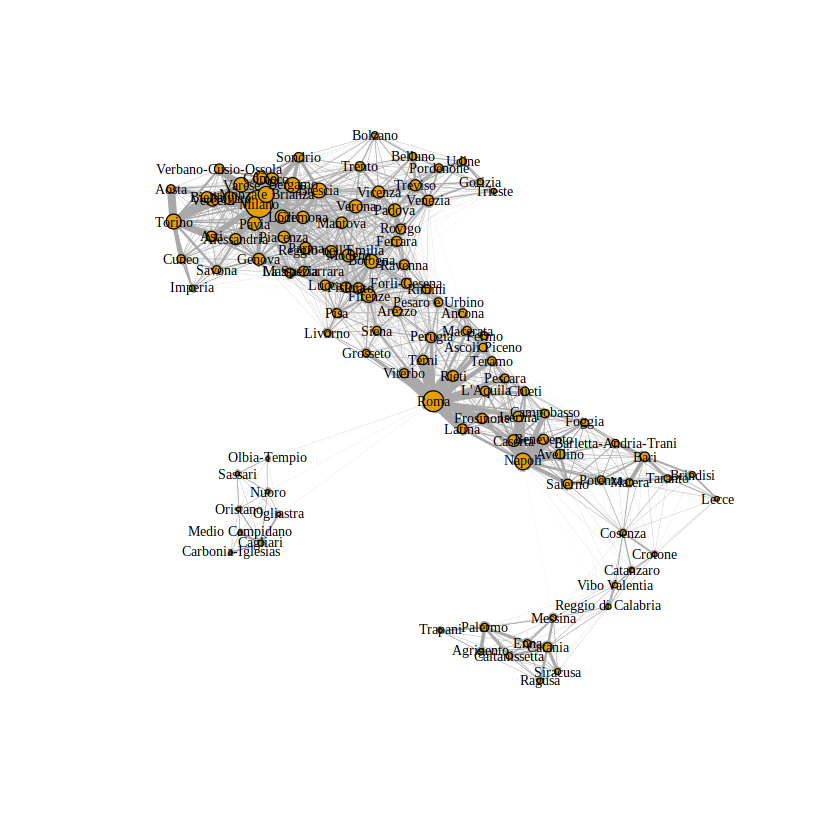

In [22]:
plot(g, layout = layout,
     vertex.label = V(g)$label,
     vertex.label.cex = 0.7,
     vertex.label.color = "black",
     vertex.size = 10 * sizes_nodes / max(sizes_nodes),
     edge.arrow.size = 0.05,
     edge.arrow.width = 0.05,
     edge.width = 15 * sizes_edges / max(sizes_edges))

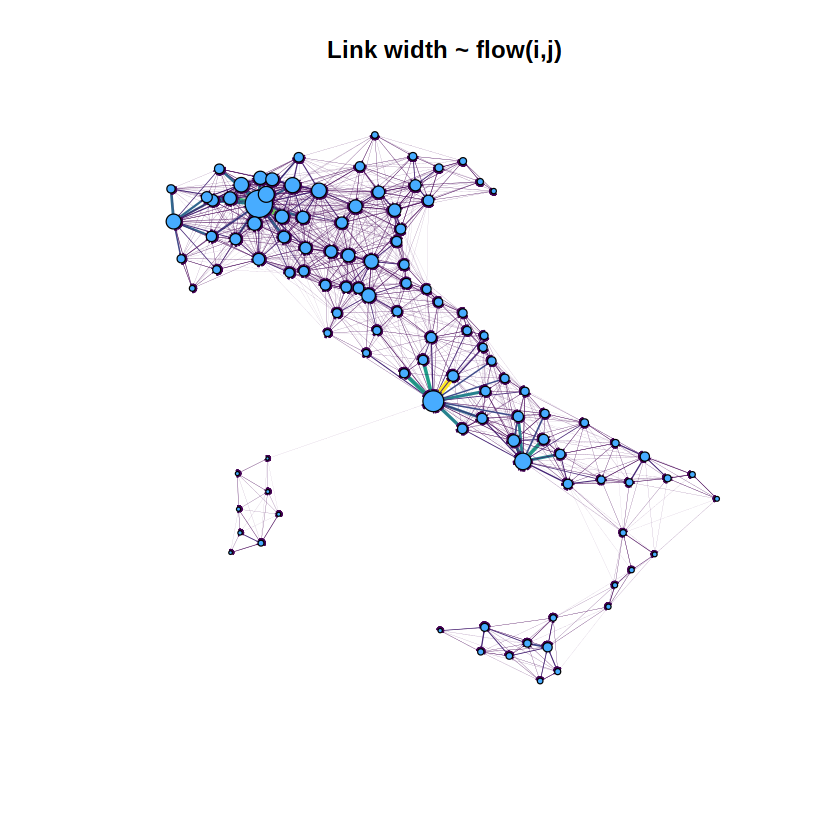

In [23]:
w <- E(g)$weight
edge_colors <- vec2pal(w, mypal)
sizes_edges <- w

plot(g, layout = layout,
     vertex.label = NA,
     vertex.label.cex = 0.5,
     vertex.label.color = "#181616",
     vertex.color = "#47acff",
     vertex.size = 10 * sizes_nodes / max(sizes_nodes),
     edge.arrow.size = 0.05,
     edge.arrow.width = 0.05,
     edge.width = 5 * sizes_edges / max(sizes_edges),
     edge.color = edge_colors,
     main = "Link width ~ flow(i,j)")

In [ ]:
RadiationModel <- function(i, j, alpha, beta, k, d0){
  num <- nodes$population[i]^alpha * nodes$population[j]^beta
  den <- exp(distancies[i, j]/d0)

  return (k * num / den)
}

RadiationModel(1, 5, 0.5, 1, 0.005, 10000)